In [1]:
import meshio
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/zhome/71/c/146676/material_tensor_tomo')
from xrd_simulator_addons import get_ground_truth_slice
import multiprocessing as mp
import yaml
import h5py
import re
import glob
from tqdm import tqdm
import utils.polar as polar
from functools import partial
import cupy as cp
from mumott.spherical_harmonics import SphericalHarmonics
from mumott.gaussian_kernels import GaussianKernels
import mumott.geometry as geometry
import mumott.odf_geometry as odf_geometry
import cil_addons.odfsh_operator as odfsh_operator
from cil.framework import ImageGeometry, ImageData, AcquisitionData, AcquisitionGeometry, BlockDataContainer
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.operators import CompositionOperator, BlockOperator
from cil.optimisation.algorithms import CGLS, SIRT
from cil.optimisation.functions import IndicatorBox


/zhome/71/c/146676/miniconda3/envs/cil/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


config_path = 'xrd_simulator_addons/configs/config_crystal_exp3.yaml'

with open(config_path, "r",encoding="utf-8") as f:
    config = yaml.safe_load(f)
absolute_path = config["absolute_path"]
session_name = config["session_name"]
N_angles = config["experiment"]["number_of_angles"]
angles = np.linspace(0,np.pi, N_angles)
N_translations = config["experiment"]["number_of_translations"]
integrated_path = absolute_path +'/' +session_name + '/integrated.h5'

/dtu-compute/msaca/simulated_data/diffraction/reference_183960_FeCr2O4_chro/integrated.h5
/dtu-compute/msaca/simulated_data/diffraction/reference_180326_Na(AlSi3O8)_alb/integrated.h5
/dtu-compute/msaca/simulated_data/diffraction/reference_30861_Titanomagnetite/integrated.h5
/dtu-compute/msaca/simulated_data/diffraction/reference_184824_Ca5(PO4)3Cl_chl/integrated.h5


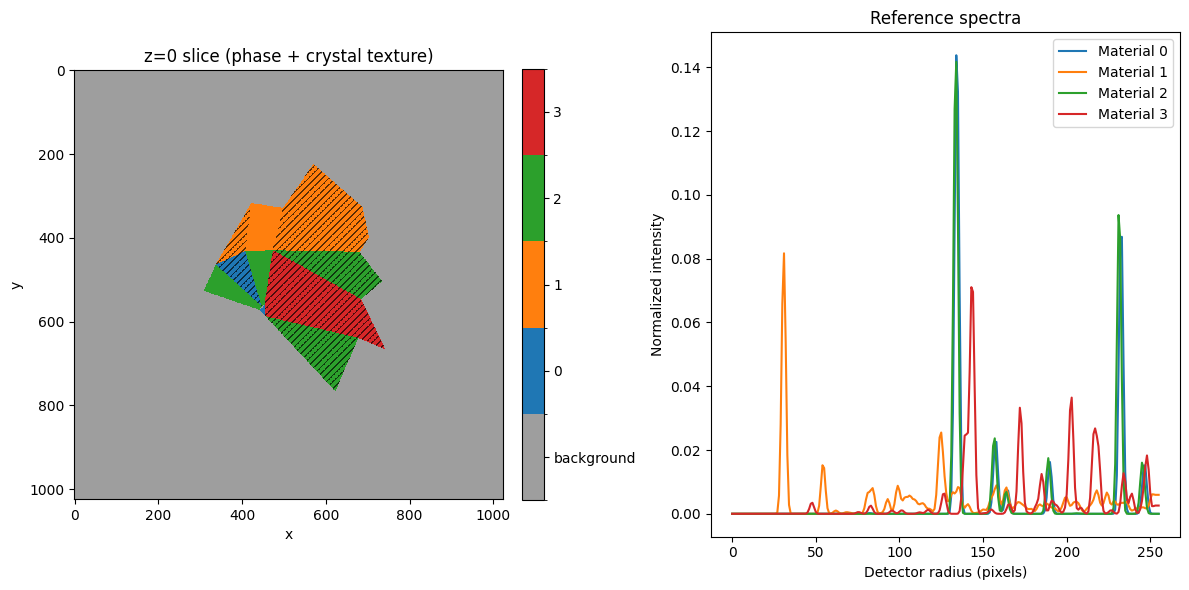

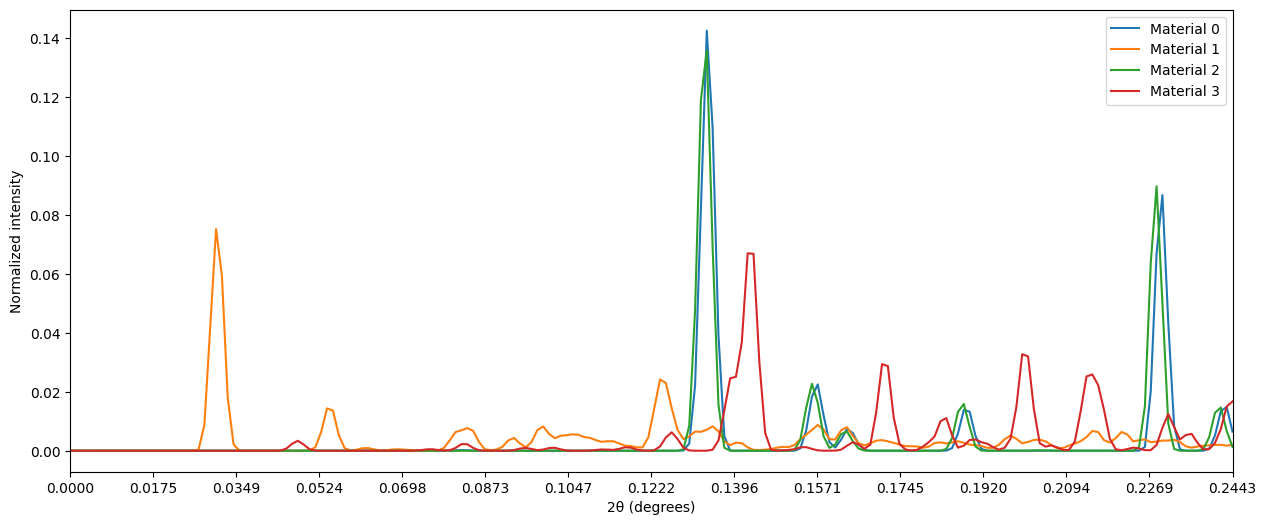

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import h5py

# --- Load maps ---
phase_map, crystal_map = get_ground_truth_slice.get_ground_truth(config=config_path)

materials = config["materials"]["files"]
spec = []
for m in materials:
    reference_path = absolute_path + '/reference_' + m[:-4] + '/integrated.h5'
    print(reference_path)
    with h5py.File(reference_path, "r") as f:
        s = f["integrated_p"][:][0, 1, :]
        spec.append(s / s.sum())
spec = np.array(spec)   # shape (n_spec, n_radius)

n_spec = len(spec)

# --- Colormaps ---
# First grey for background, then default cycle colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#9e9e9e'] + default_colors
if n_spec > len(colors)-1:   # ensure enough
    from itertools import cycle, islice
    colors = ['#9e9e9e'] + list(islice(cycle(default_colors), n_spec))

cmap = ListedColormap(colors[:n_spec+1])

# bounds: background = -1, then 0..n_spec-1
bounds = [-1.5] + [i-0.5 for i in range(n_spec)] + [n_spec-0.5]
norm = BoundaryNorm(bounds, cmap.N)

# optional: per-class cmaps
new_cmaps = []
for i, color in enumerate(cmap.colors):
    new_cmaps.append(
        LinearSegmentedColormap.from_list(f"class_{i}", ["white", color])
    )

# --- Create figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Left: phase + crystal texture
im = ax1.imshow(phase_map, interpolation='nearest',
                cmap=cmap, norm=norm)

ny, nx = crystal_map.shape
xx, yy = np.meshgrid(np.arange(nx), np.arange(ny))
stripe = ((xx + 1*yy) % 16) < 4
mask = (crystal_map != 0)

alpha = (mask & stripe).astype(float) * 0.65
overlay = np.zeros((ny, nx, 4), dtype=float)
overlay[..., 3] = alpha
ax1.imshow(overlay, interpolation='nearest')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('z=0 slice (phase + crystal texture)')

# adjustable colorbar
ticks = [-1] + list(range(n_spec))
labels = ['background'] + [str(i) for i in range(n_spec)]
cbar = plt.colorbar(im, ax=ax1, ticks=ticks, fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(labels)

# Right: spectra
for i in range(n_spec):
    ax2.plot(spec[i], color=colors[i+1], label=f"Material {i}")
ax2.set_title("Reference spectra")
ax2.set_xlabel("Detector radius (pixels)")
ax2.set_ylabel("Normalized intensity")
ax2.legend()

plt.tight_layout()
plt.show()

# --- Convert spectra to 2θ ---
detector_distance = config["experiment"]["detector_distance"]
pixel_size = config["experiment"]["pixel_size"]
max_rad = 256
r_max = pixel_size * max_rad
two_theta_new = np.linspace(0, 14, 200)*np.pi/180

spec_2theta = polar.spectra_radius_to_twotheta(
    spec,
    two_theta_new,
    detector_distance,
    r_max)

# --- Plot in 2θ space ---
fig, ax = plt.subplots(figsize=(15, 6))
for i in range(spec_2theta.shape[0]):
    ax.plot(two_theta_new, spec_2theta[i,:], color=colors[i+1], label=f"Material {i}")

ax.set_xlim(two_theta_new.min(), two_theta_new.max())
ax.set_xticks(np.linspace(two_theta_new.min(), two_theta_new.max(), 15))
ax.set_xlabel('2θ (degrees)')
ax.set_ylabel('Normalized intensity')
ax.legend()

plt.show()


In [5]:
# Inspect the plot above, to identify peask with a single phase.

In [8]:
def extract_index(filename):
    match = re.search(r'angle_(\d+)\.h5', filename)
    return int(match.group(1)) if match else -1

# Load and stack patterns from one file
def load_one_file(filename):
    with h5py.File(filename, 'r') as f:
        patterns = [f[key][:] for key in sorted(f.keys())]
        return np.stack(patterns)  # shape: (num_j, H, W)
    

session_name = config["session_name"]
absolute_infolder = config["absolute_path"]
inpath = os.path.join(absolute_infolder, f"{session_name}")
files = sorted(glob.glob(inpath + "/angle_*.h5"), key=extract_index)
with mp.Pool(processes=32) as pool:
    all_patterns = list(
        tqdm(pool.imap(load_one_file, files), total=len(files))
    )
diffraction_4d = np.stack(all_patterns)  # (num_angles, num_j, H, W)
num_angles, num_j, H, W = diffraction_4d.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:18<00:00,  9.91it/s]


In [9]:


pol, max_rad = polar.cartesian_to_polar(diffraction_4d[0,32,:,:], num_phi=360,factor = 3)
detector_distance = config["experiment"]["detector_distance"]
pixel_size = config["experiment"]["pixel_size"]
r_max = pixel_size*max_rad
two_theta = np.linspace(0, 14, 200)*np.pi/180
pol_reb = polar.detector_radius_to_twotheta(
    det_array=pol,
    two_theta_new=two_theta,  # degrees
    detector_distance=detector_distance,   # mm
    r_max=r_max                # mm
)


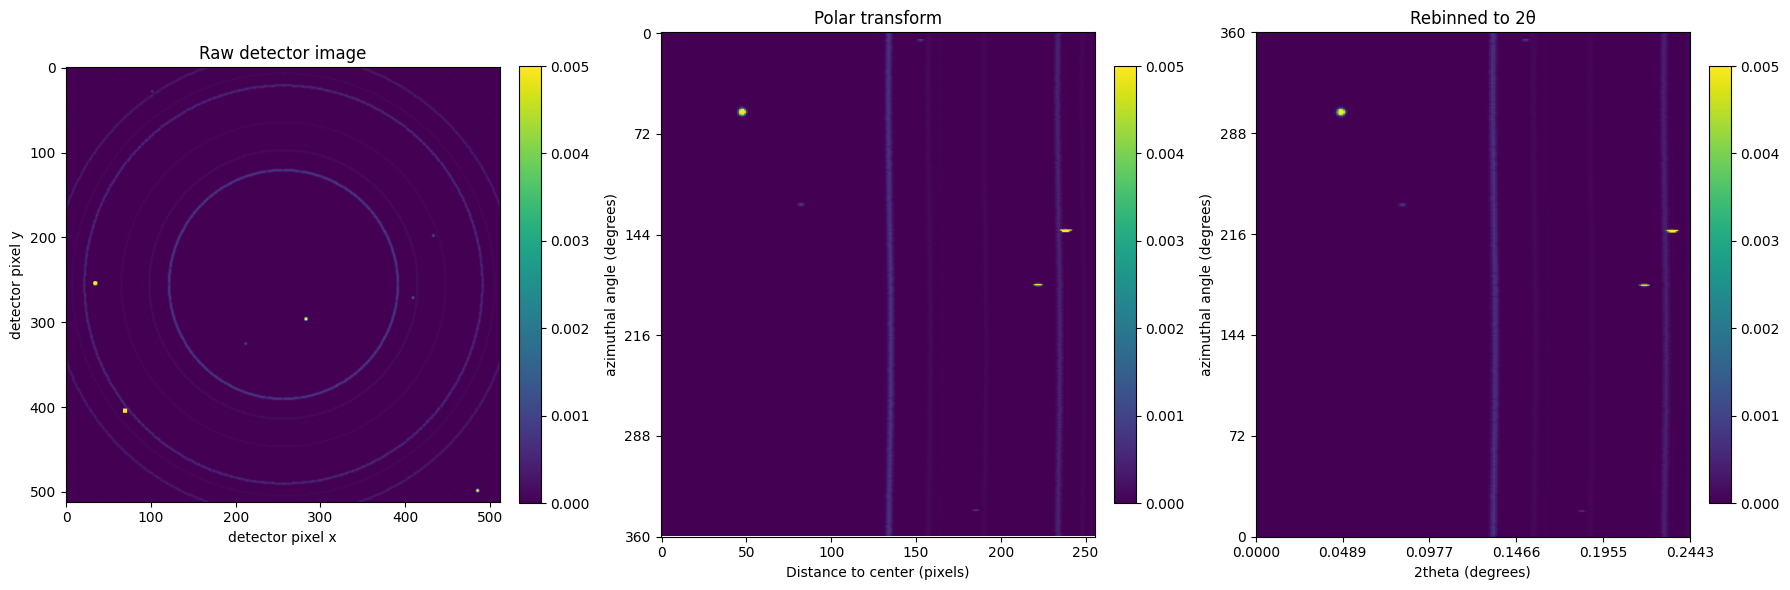

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# --- First plot: detector image ---
im1 = ax1.imshow(diffraction_4d[0, 32, :, :])
im1.set_clim([0, 0.005])
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlabel("detector pixel x")
ax1.set_ylabel("detector pixel y")
ax1.set_title("Raw detector image")

# --- Second plot: polar transform (r, azimuth) ---
im2 = ax2.imshow(pol, aspect='auto')
im2.set_clim([0, 0.005])
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_xlabel("Distance to center (pixels)")
ax2.set_ylabel("azimuthal angle (degrees)")
y_min, y_max = 0, 360
ax2.set_yticks(np.linspace(y_min, y_max, 6))
ax2.set_title("Polar transform")

# --- Third plot: polar re-binned to 2theta ---
x_min, x_max = two_theta[0], two_theta[-1]
y_min, y_max = 0, 360
im3 = ax3.imshow(pol_reb, aspect="auto",
                 extent=[x_min, x_max, y_min, y_max])
im3.set_clim([0, 0.005])
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
ax3.set_xlabel("2theta (degrees)")
ax3.set_ylabel("azimuthal angle (degrees)")
ax3.set_xticks(np.linspace(x_min, x_max, 6))
ax3.set_yticks(np.linspace(y_min, y_max, 6))
ax3.set_title("Rebinned to 2θ")

plt.tight_layout()
plt.show()



In [11]:
print(diffraction_4d.shape)

(181, 64, 512, 512)


In [12]:
two_theta = np.linspace(0, 14, 10)*np.pi/180
out = polar.process_diffraction_cpu_to_gpu(
    diffraction_4d,          # NumPy array
    num_phi=30,
    factor=2,
    two_theta_new=two_theta,
    detector_distance=detector_distance,
    r_max=r_max,
    chunk_size=512,           # adjust based on GPU memory
    return_to_cpu=True       # results back on CPU
)
# As you can see, this works fine, but let's choose a single 2theta value, namely 1.75
print(np.shape(out))

Processing:  13%|████████████                                                                                | 3/23 [00:00<00:02,  7.10it/s]

Processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.26it/s]

(181, 64, 30, 10)


In [13]:
#two_theta = np.array([8.15,8.25, 8.35, 9.7, 9.8, 9.9, 11.4,11.5,11.6])*np.pi/180
two_theta = np.array([7.65,7.7, 7.75,7.8])*np.pi/180
#two_theta = np.array([1.75,1.8])
n_azith_bins = 60
out = polar.process_diffraction_cpu_to_gpu(
    diffraction_4d,          # NumPy array (on CPU, 9 GB)
    num_phi=n_azith_bins,
    factor=2,
    two_theta_new=two_theta,
    detector_distance=detector_distance,
    r_max=r_max,
    chunk_size=512,           # adjust based on GPU memory
    return_to_cpu=True       # results back on CPU
)
# As you can see, this works fine, but let's choose a single 2theta value, namely 1.75

#temp = out[:,:,:,0]/2 +out[:,:,:,1]/2 +out[:,:,:,2]/2 + np.sum(out[:,:,:,3:],axis=3)
temp = out
temp = temp.sum(axis=(2,3))
print(np.shape(out))
            

Processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.38it/s]

(181, 64, 60, 4)


In [14]:
from cil.framework import ImageGeometry, ImageData, AcquisitionData, AcquisitionGeometry
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.operators import CompositionOperator, BlockOperator
import cil_addons.odfsh_operator as odfsh_operator
from time import time

Nx = diffraction_4d.shape[1]
Ny = Nx
ell_max = 2
azimuthal_angles = np.linspace(0,2*np.pi, n_azith_bins, endpoint=False)

M_rot = 181
rotations = np.linspace(0,np.pi,M_rot)

M_two_theta, M_az = len(two_theta),len(azimuthal_angles)
M = M_two_theta*M_az
px, py = 1.0, 1.0

t1 = time()
#og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, ell_max=ell_max, two_theta=two_theta, rotation = rotations)
og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, two_theta=two_theta, rotation = rotations, grid_scale=4, kernel_scale_parameter=1.0)
probes = og.build_probed_coordinates()
#basis = SphericalHarmonics(ell_max=ell_max, probed_coordinates=probes)
basis = GaussianKernels(grid_scale = 4, kernel_scale_parameter=10.0, probed_coordinates=probes)
K = basis.projection_matrix.shape[1]


In [15]:

print('Operator parameters:\n Number of zimuthal bins: ', M_az,
      '\n Number of 2theta bins: ', M_two_theta,
      '\n Number of pixels for the slice: ', Nx, Ny,
      '\n Number of detector translations: ', Nx,
      '\n Number of sample rotations: ', M_rot,
      '\n Number of Orientation basis functions: ', K)
t2 = time()

ig_M = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=M, center_x=0, center_y=0, center_z=0)
ig_K = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=K, center_x=0, center_y=0, center_z=0)
ag_K = AcquisitionGeometry.create_Parallel3D() \
    .set_panel(num_pixels=(Nx, K), pixel_size=(px, py)) \
    .set_angles(rotations, angle_unit='radian') \
    .set_labels(['vertical','angle', 'horizontal'])
ag_M = AcquisitionGeometry.create_Parallel3D() \
    .set_panel(num_pixels=(Nx, M), pixel_size=(px, py)) \
    .set_angles(rotations, angle_unit='radian') \
    .set_labels(['angle', 'horizontal', 'vertical'])

t3 = time()
B = odfsh_operator.ODFGKOperator2d_fast_ag(odf_geometry=og, ag_in = ag_K, ag_out=ag_M, indices=range(M_rot))
#B = odfsh_operator.ODFSHOperator2d_fast_ag(odf_geometry=og, ag_in = ag_K, ag_out=ag_M, indices=range(M_rot))
t4 = time()


A = ProjectionOperator(ig_K, ag_K, device='gpu')             # set device/backend as needed
t5 = time()

T = CompositionOperator(B, A)

Operator parameters:
 Number of zimuthal bins:  60 
 Number of 2theta bins:  4 
 Number of pixels for the slice:  64 64 
 Number of detector translations:  64 
 Number of sample rotations:  181 
 Number of Orientation basis functions:  100


In [16]:
print(M_rot)

181


In [17]:
### Apply CGLS
#### Get B using Pool. Apply B using pool
b = AcquisitionData(out.reshape((M_rot, Nx, M)).astype(np.float32), geometry = ag_M)

In [18]:
print(b.as_array().shape)

A.adjoint(B.adjoint(b))

B.direct(A.direct(A.adjoint(B.adjoint(b))))
T.adjoint(b)

(181, 64, 240)


In [19]:
constraint = IndicatorBox(lower=0)
sirt = SIRT(initial=ig_K.allocate(0), operator=T, data=b, max_iteration=100, constraint=constraint)
sirt.run(40)
sol = sirt.solution
sol_np = sol.as_array()

 10%|████████▌                                                                             | 4/40 [00:00<00:04,  8.58it/s, objective=0.0174]

100%|█████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.32it/s, objective=0.0173]


In [20]:
# cgls = CGLS(initial=ig_K.allocate(0), operator=T, data=b, max_iteration=100)
# cgls.run(10)
# sol = cgls.solution
# sol_np = sol.as_array()

In [21]:
sorted_indices = np.argsort(sol_np.sum(axis=(1,2)))[::-1]
print(sorted_indices)

[85  8 84 63 96 77  5 42 45 38 95 37 66 67 78 41 71 39 48 61 62 19  6 40
 72 82 58 73 46 94 79 76 44 89 81 80 88 47 87 68 18  3 64 83 65 56  2  7
 86 32  1 55 10 90 24 98  0 49 33 50 20 43 36 25  4 34 21 52 70 60 22 26
 23  9 54 28 92 27 74 51 35 53 59 75 99 11 30 69 16 57 29 31 97 93 14 15
 12 13 91 17]


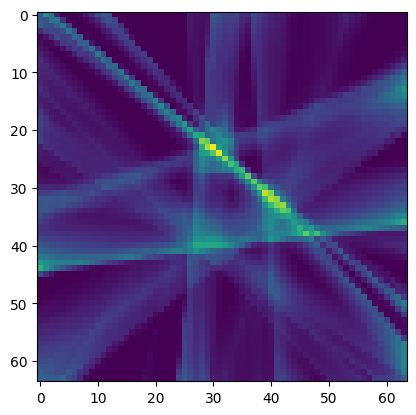

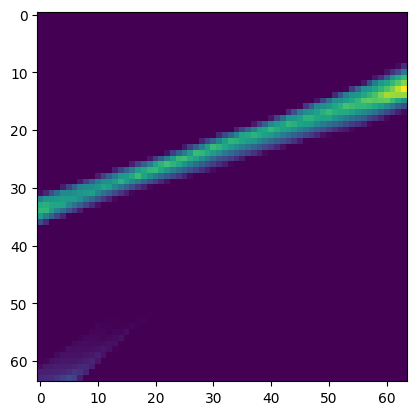

In [22]:
plt.imshow(np.sum(sol_np,axis=0))
plt.show()
plt.imshow(sol_np[sorted_indices[5]])
plt.show()

In [ ]:
###### Next up: Apply forward model, to see if we can hit the crystal

In [ ]:
Nx = diffraction_4d.shape[1]
Ny = Nx
n_azith_bins = 60
azimuthal_angles = np.linspace(0,2*np.pi, n_azith_bins, endpoint=False)
ell_max = 1
n_segments = 3
M_rot = 181

rotations = np.linspace(0,np.pi,M_rot, endpoint=True)
M_rot = len(rotations)


og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, ell_max=ell_max, two_theta=two_theta, rotation=0.0)
probes = og.build_probed_coordinates()
print(probes.vector.shape)
sharm = SphericalHarmonics(ell_max=ell_max, probed_coordinates=probes)
K = len(sharm.ell_indices)

azimuthal_angles = np.linspace(0,2*np.pi, n_azith_bins, endpoint=False)


M_two_theta, M_az = len(two_theta),len(azimuthal_angles)
M = M_two_theta*M_az
ig_M = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=M, center_x=0, center_y=0, center_z=0)
ig_K = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=K, center_x=0, center_y=0, center_z=0)
Nu, Nv = Nx, M 
px, py = 1.0, 1.0  # detector pixel size (set to your values)

ag_base = AcquisitionGeometry.create_Parallel3D() \
    .set_panel(num_pixels=(Nu, Nv), pixel_size=(px, py)) \
    .set_angles([0.0], angle_unit='radian')
og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, ell_max=ell_max, two_theta=two_theta, rotation = rotations)
probed_coords = og.build_probed_coordinates()
print(probed_coords.vector.shape)
#Br = odfsh_operator.ODFSHOperator2d_fast(odf_geometry=og, ig_in = ig_K, ig_out=ig_M)


TypeError: 'float' object is not iterable

In [ ]:
Nx = diffraction_4d.shape[1]
Ny = Nx
n_azith_bins = 60
azimuthal_angles = np.linspace(0,2*np.pi, n_azith_bins, endpoint=False)
ell_max = 1
n_segments = 3

rotations = np.linspace(0, np.pi,181, endpoint=True)
M_rot = len(rotations)


og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, ell_max=ell_max, two_theta=two_theta, rotation=0.0)
probes = og.build_probed_coordinates()
print(probes.vector.shape)
sharm = SphericalHarmonics(ell_max=ell_max, probed_coordinates=probes)
K = len(sharm.ell_indices)

azimuthal_angles = np.linspace(0,2*np.pi, n_azith_bins, endpoint=False)


M_two_theta, M_az = len(two_theta),len(azimuthal_angles)
M = M_two_theta*M_az
ig_M = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=M, center_x=0, center_y=0, center_z=0)
ig_K = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=K, center_x=0, center_y=0, center_z=0)
Nu, Nv = Nx, M 
px, py = 1.0, 1.0  # detector pixel size (set to your values)

ag_base = AcquisitionGeometry.create_Parallel3D() \
    .set_panel(num_pixels=(Nu, Nv), pixel_size=(px, py)) \
    .set_angles([0.0], angle_unit='radian')
# placeholder; we overwrite per use
def make_Pr(angle_deg):
    ag = ag_base.copy()
    ag.set_angles([angle_deg])  # 1 angle for this operator
    # Domain is M-channel volume (output of B_r), so operator expects ig_M
    return ProjectionOperator(ig_M, ag)             # set device/backend as needed


Br_ops = []
Pr_ops = []

for i in range(len(rotations)):
        og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles, ell_max=ell_max, two_theta=two_theta, rotation = rotations[i])
        Br = odfsh_operator.ODFSHOperator2d_fast(odf_geometry=og, ig_in = ig_K, ig_out=ig_M)
        Pr = make_Pr(rotations[i])
        Br_ops.append(Br)
        Pr_ops.append(Pr)

C_rows = [CompositionOperator(Pr_ops[r] , Br_ops[r])  for r in range(len(rotations)) ]   # composition per rotation
# Make a 'tall' BlockOperator with R rows and 1 column
print(*C_rows)
T = BlockOperator(*C_rows, shape=(len(rotations),1))

(1, 540, 3, 3)
<cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb4432e890> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb442a8e10> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb46d707d0> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb44daf050> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb44366f50> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb441f1e90> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb29065750> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb28f05790> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb28fd4990> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb441d4590> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fdb441fb610> <cil.optimisation.operators.Operator.CompositionOperator object at 0x7fd

In [132]:
data_in = np.zeros((K,Nx,Ny), dtype=np.float32)
data_in = ImageData(data_in, geometry=ig_K)
data_out = T.direct(data_in)
print(type(data_out[0]))
ag = data_out[0].geometry

<class 'cil.framework.acquisition_data.AcquisitionData'>


In [133]:
out = out.reshape((M_rot, N_translations, M))
def make_acq(i):
    b_i = out[i].squeeze().transpose([1,0]).astype(np.float32)
    b_i = AcquisitionData(array=b_i, geometry=ag)
    return b_i

In [94]:
acq_list = [make_acq(i) for i in range(M_rot)]   # placeholder for however you create b[i]
# build the BlockDataContainer in one go
b = BlockDataContainer(*acq_list)

In [95]:
cgls = CGLS(initial=ig_K.allocate(0), operator=T, data=b, max_iteration=100)
cgls.run(10)
# constraint = IndicatorBox(lower=0, upper = 0.000001)
# sirt = SIRT(initial=ig_K.allocate(0), operator=T, data=b, max_iteration=100, constraint=constraint)
# sirt.run(10)

100%|██████████| 10/10 [01:15<00:00,  7.58s/it, objective=1.41]


In [96]:
from cil.optimisation.algorithms import PDHG
from cil.optimisation.functions import LeastSquares, IndicatorBox,L2NormSquared
from cil.optimisation.operators import IdentityOperator


# f: data fidelity on Ax
f = L2NormSquared(b=b)

# g: nonnegativity constraint on x
g = IndicatorBox(lower=0)

# Set up PDHG
pdhg = PDHG(f=f, g=g, operator=T, initial=ig_K.allocate(0))

In [97]:
pdhg.run(10, verbose=2)

100%|██████████| 10/10 [02:32<00:00, 15.24s/it, primal=1.41, dual=0.00321, primal_dual=1.41]


CGLS solution norm: 3.749407e-05
(4, 64, 64)


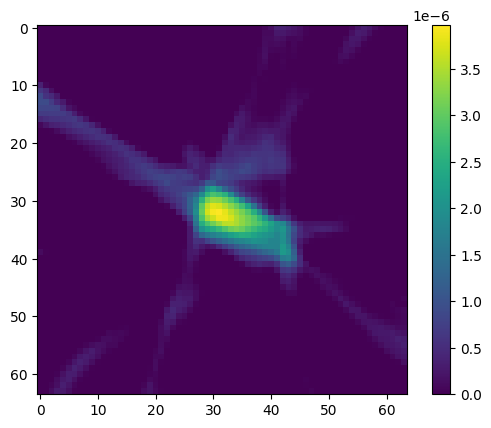

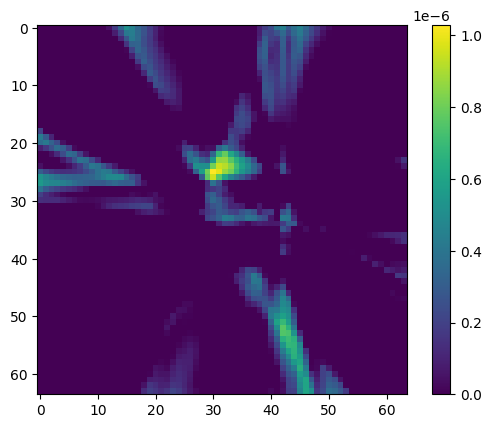

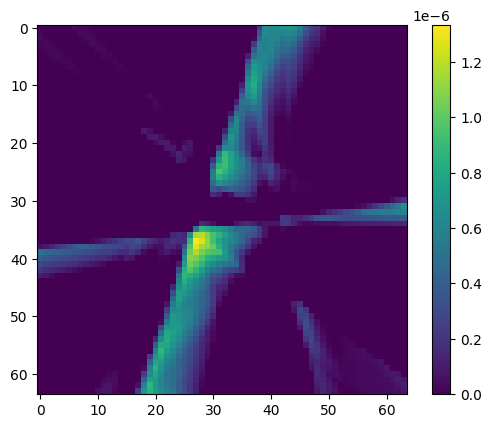

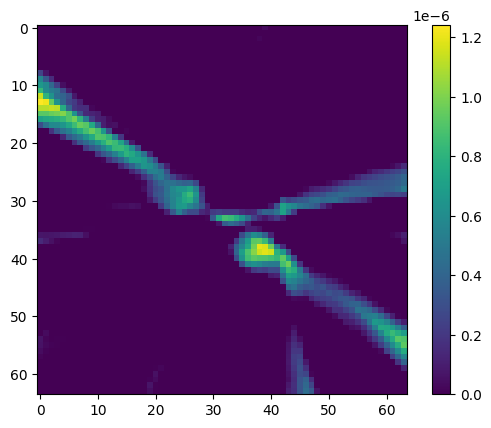

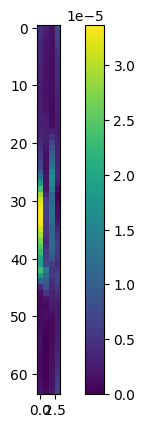

CGLS solution norm: 7.1013485e-05
(4, 64, 64)


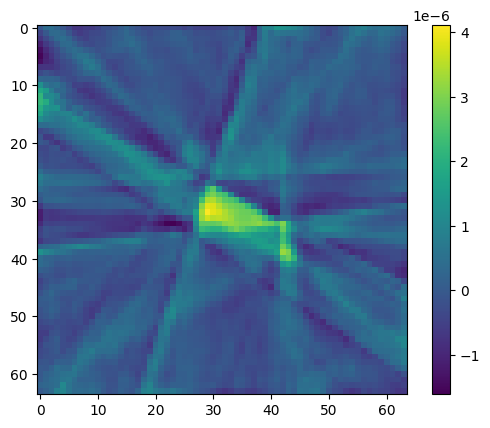

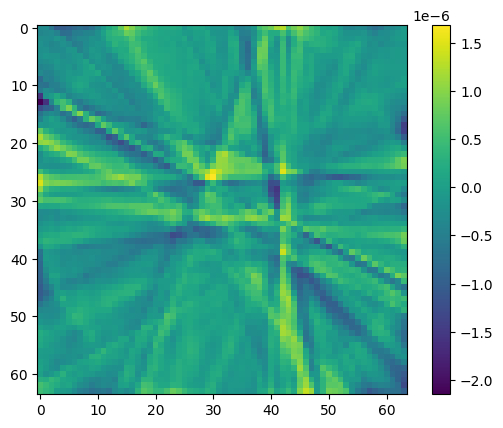

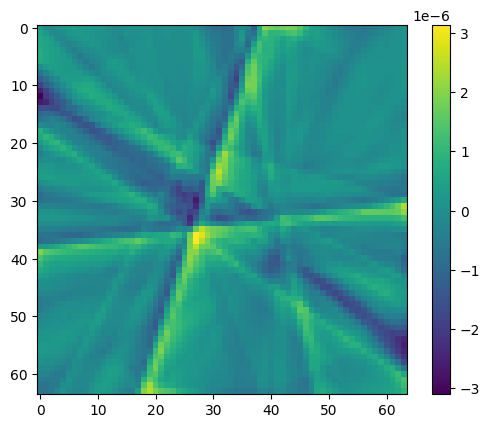

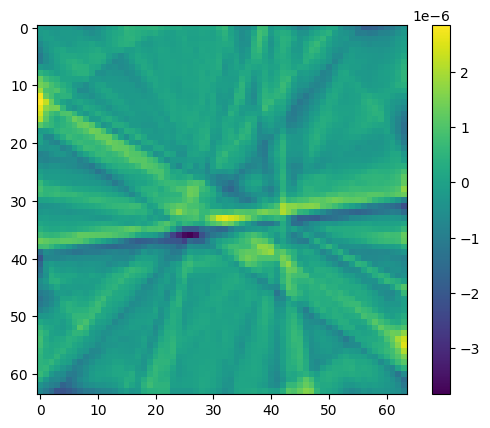

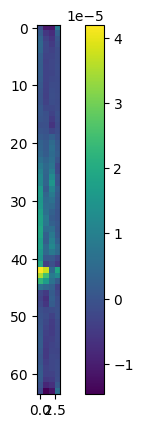

In [127]:
x_sirt = pdhg.solution
print("CGLS solution norm:", x_sirt.norm())
print(x_sirt.as_array().shape)
for i in range(K):
    # plt.imshow(data_in.as_array()[i])
    # plt.clim([0,4])
    # plt.colorbar()
    # plt.show()
    plt.imshow(x_sirt.as_array()[i].T)
    #plt.clim([0,4])
    plt.colorbar()
    plt.show()
    # plt.imshow(data_in.as_array()[i]-x_cgls.as_array()[i])
    # plt.clim([-1,1])
    # plt.colorbar()
    # plt.show()



plt.imshow(np.sum(x_sirt.as_array()[:].T,axis=0))
#plt.clim([0,4])
plt.colorbar()
plt.show()


x_cgls = cgls.solution
print("CGLS solution norm:", x_cgls.norm())
print(x_cgls.as_array().shape)
for i in range(K):
    # plt.imshow(data_in.as_array()[i])
    # plt.clim([0,4])
    # plt.colorbar()
    # plt.show()
    plt.imshow(x_cgls.as_array()[i].T)
    #plt.clim([0,4])
    plt.colorbar()
    plt.show()
    # plt.imshow(data_in.as_array()[i]-x_cgls.as_array()[i])
    # plt.clim([-1,1])
    # plt.colorbar()
    # plt.show()



plt.imshow(np.sum(x_cgls.as_array()[:].T,axis=0))
#plt.clim([0,4])
plt.colorbar()
plt.show()

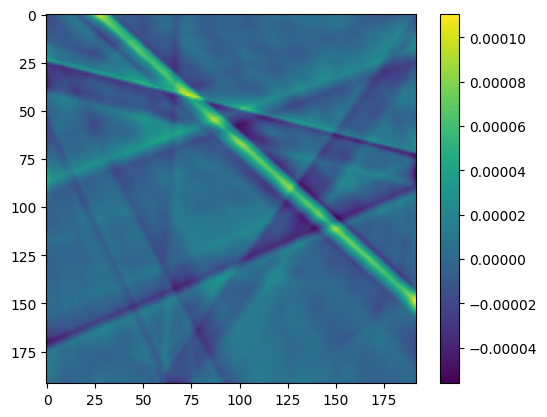

In [120]:

plt.imshow(np.sum(x_cgls.as_array()[:],axis=0))
#plt.clim([0,4])
plt.colorbar()
plt.show()

In [101]:
def make_acq(i):
    b_i = out[i].squeeze().transpose([1,0]).astype(np.float32)
    b_i[b_i>0.0005] = 0
    b_i = AcquisitionData(array=b_i, geometry=ag)
    return b_i


acq_list = [make_acq(i) for i in range(181)]   # placeholder for however you create b[i]
# build the BlockDataContainer in one go
b = BlockDataContainer(*acq_list)

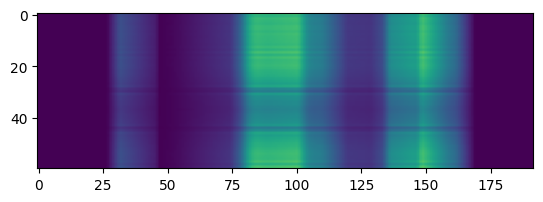

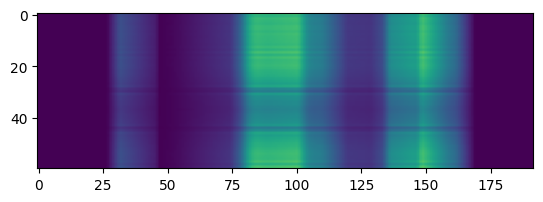

In [102]:
b_i = out[i].squeeze().transpose([1,0]).astype(np.float32)
b_high = np.clip(b_i, 0.0005,100000).astype(np.float32)

plt.imshow(b_i)
plt.clim([0,0.0005])
plt.show()

b_i[b_i>0.0005] = 0
plt.imshow(b_i)
plt.clim([0,0.0005])
plt.show()

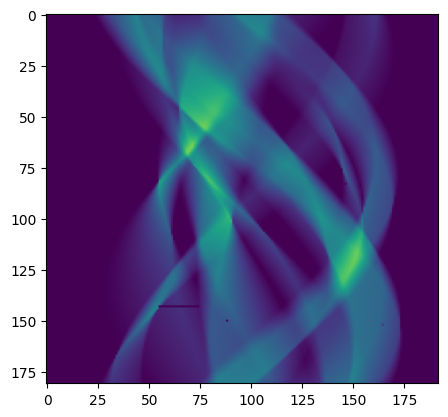

In [103]:
sino = []
for i in range(181):
    sino.append((b[i].as_array()))
sino = np.stack(sino)

plt.imshow(np.sum(sino[:,:,:],axis=1))
sino = []
for i in range(181):
    sino.append((b[i].as_array()))
sino = np.stack(sino)

plt.imshow((sino[:,30,:]))
plt.clim([0,0.0005])

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 62.29it/s, objective=3.47]


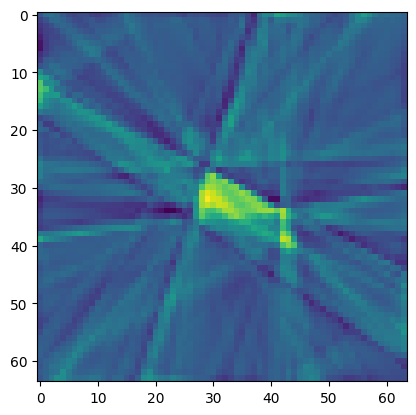

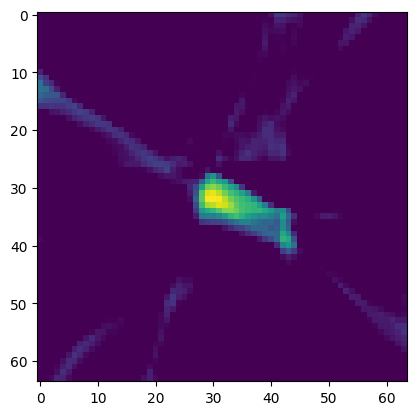

In [ ]:
ig = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, center_x=0, center_y=0)
ag = AcquisitionGeometry.create_Parallel2D() \
    .set_panel(num_pixels=(Nu), pixel_size=(px)) \
    .set_angles(np.linspace(0,np.pi,181, endpoint=True), angle_unit='radian')

data = AcquisitionData(array=temp.astype(np.float32), geometry=ag)

A = ProjectionOperator(ig, ag)
cgls_simple = CGLS(initial=ig.allocate(0), operator=A, data=data, max_iteration=100)

# f: data fidelity on Ax
f = L2NormSquared(b=data)

# g: nonnegativity constraint on x
g = IndicatorBox(lower=0)

# Set up PDHG
pdhg_simple = PDHG(f=f, g=g, operator=A, initial=ig.allocate(0))

cgls_simple.run(10)
pdhg_simple.run(10)
x_cgls_simple = cgls_simple.solution
x_pdhg_simple = pdhg_simple.solution
plt.imshow(x_cgls_simple.as_array().T)
plt.show()
plt.imshow(x_pdhg_simple.as_array().T)
plt.show()